# Vehicle Detection Tutorial

### Support Vector Machine vs YOLO V2

In [1]:
# Util libraries
import cv2
import os, fnmatch
import numpy as np
import time
import itertools

#  SVC and YOLO classifier
from utils import SupportVectorMachineClassifier, YOLOV2

# Helper functions
from sklearn.preprocessing import StandardScaler
from utils import get_feature, extract_feature

# Visualiztion
import matplotlib.pyplot as plt
%matplotlib inline

## Import Dataset

In [2]:
# Get list of filenames
def get_file_names(src_path='./', pattern='*.jpeg'):
    # Return a list of file names in a given folder with certain pattern
    images = []
    for root, dir_names, file_names in os.walk(src_path):
        for filename in fnmatch.filter(file_names, pattern):
            images.append(os.path.join(root, filename))
    return images

In [3]:
# Import car and not car images
cars = get_file_names('./data/vehicles', pattern='*.png')
not_cars = get_file_names('./data/non-vehicles', pattern='*.png')
print("Car Images :{} images\nNot Car Images: {} images".format(len(cars),len(not_cars)))

Car Images :8792 images
Not Car Images: 8968 images


## Data Exploration

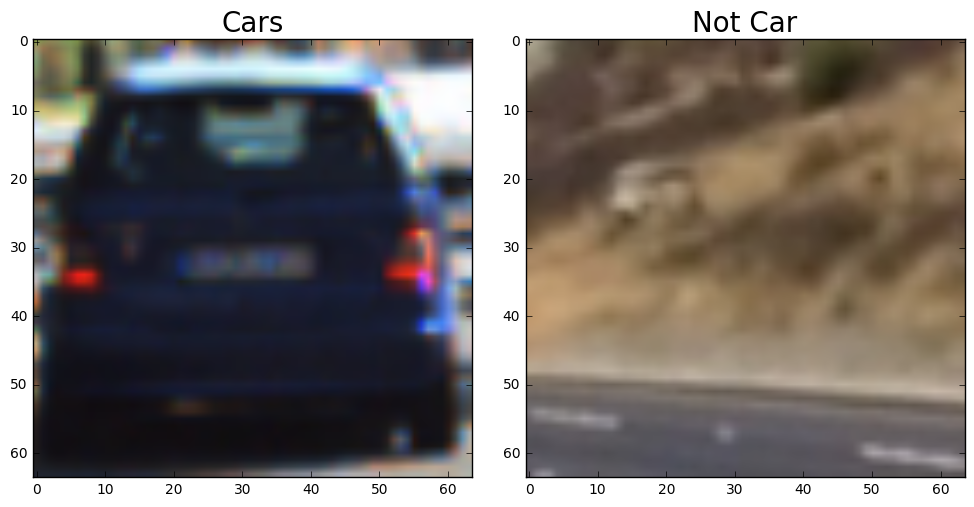

In [4]:
# Data Exploration
idx = np.random.randint(0, len(cars))
imgs = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in (cars[idx], not_cars[idx])]
a, fg = plt.subplots(1,2, figsize=(10, 5))
a.tight_layout()
fg[0].imshow(imgs[0])
fg[0].set_title("Cars", fontsize=20)
fg[1].imshow(imgs[1])
fg[1].set_title("Not Car", fontsize=20)

### Contrast Normalization before extracting feature

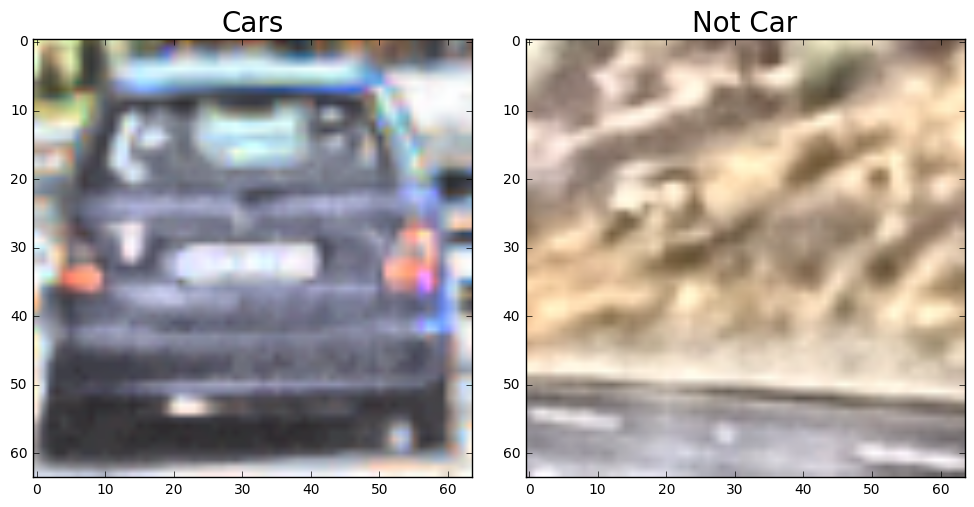

In [5]:
def adaptive_equalize_image(gray_img, level):
    """
    Equalize an image - Increase contrast for the image
    # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    :param img:    an gray image
    :param level:  clipLevel
    :return: a equalized image
    """
    clahe = cv2.createCLAHE(clipLimit=level)
    if gray_img.shape[2] == 3:
        lab = cv2.cvtColor(gray_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        result = cv2.merge((cl, a, b))
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
        
    else:
        result = clahe.apply(img)
    return result

eql_imgs = [adaptive_equalize_image(img, 3.0) for img in imgs]

a, fg = plt.subplots(1,2, figsize=(10, 5))
a.tight_layout()
fg[0].imshow(eql_imgs[0])
fg[0].set_title("Cars", fontsize=20)
fg[1].imshow(eql_imgs[1])
fg[1].set_title("Not Car", fontsize=20)


### Features in Car and Not Car Images - Histogram of Gradient, Color Histogram, Spatial Binary

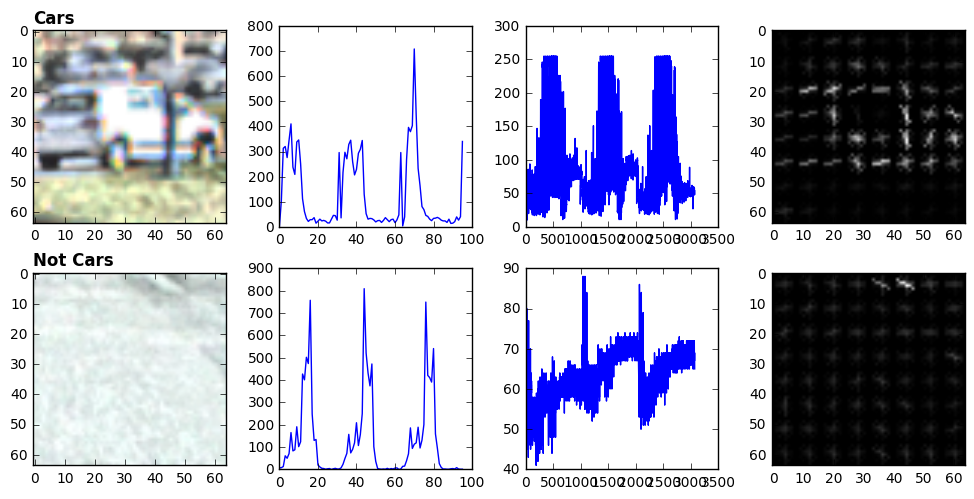

In [6]:
from utils import get_hog_features, color_hist, bin_spatial

idx = np.random.randint(0, len(cars))
imgs = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in (cars[idx], not_cars[idx])]

a, fg = plt.subplots(2,4, figsize=(10, 5))
a.tight_layout()
txt = ("Cars", "Not Cars")
for idx, img in enumerate(imgs):
    color = color_hist(img)
    _, hog = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    spatial_bin = bin_spatial(img)
    fg[idx, 0].set_title(txt[idx],loc='left', fontweight='bold')
    fg[idx, 0].imshow(adaptive_equalize_image(img, 3.0))
    fg[idx, 1].plot(color)
    fg[idx, 2].plot(spatial_bin)
    fg[idx, 3].imshow(hog, cmap='gray')

## Extract Combined Feature Vector for Car and Not-Car Images



### Pre-propcessing:
`adaptive_histogram_equalization`: **True**

### HOG Parameters

| Parameters      | Value |
|: -------------- |------:| 
| `orientation`   | 9     |
| `pix_per_cell`  | 8     | 
| `cell_per_block`| 2     | 
| `hog_channel`   | `'ALL`|
| `transform_srt` | False |
| `feature_vector`| True  |

### Color Histogram Parameters:
| Parameters   | Value     |
|: ----------- |----------:| 
| `nbins`      | 32        |
| `bin_range`  | (0.0, 1.0)| 


### Spatial Bin Parameters:
| Parameters   | Value   |
|: ----------- |--------:| 
| `color_space`| `YCrCb` |
| `spatial_bin`| (32, 32)| 
spatial_size = (32, 32)


In [7]:
# Calculate car features & not-car features
t = time.time()
# Workers for parallel multi processing, please change based on your CPU.
# The Adaptive Histogram Equalization will significantly increase the processing time.

print("Calculating Car Feature Vector on {} images".format(len(cars)))
car_features = get_feature(cars, workers=4)
print("Calculating Not-Car Feature Vector on {} images".format(len(not_cars)))
not_car_features = get_feature(not_cars, workers=4)
print("Completed calculating feature in {:f} seconds\n".format((time.time() - t), 3))

Calculating Car Feature Vector on 8792 images
Total time: 20.947975397109985 seconds
Average time / feature : 0.006292242587317761 seconds
Max Value 0.8392156862745098 Min Value 0.058823529411764705

Calculating Not-Car Feature Vector on 8968 images
Total time: 20.71225643157959 seconds
Average time / feature : 0.006206410283174609 seconds
Max Value 1.0 Min Value 0.23529411764705882

Completed calculating feature in 41.770857 seconds



Feature length:  8460


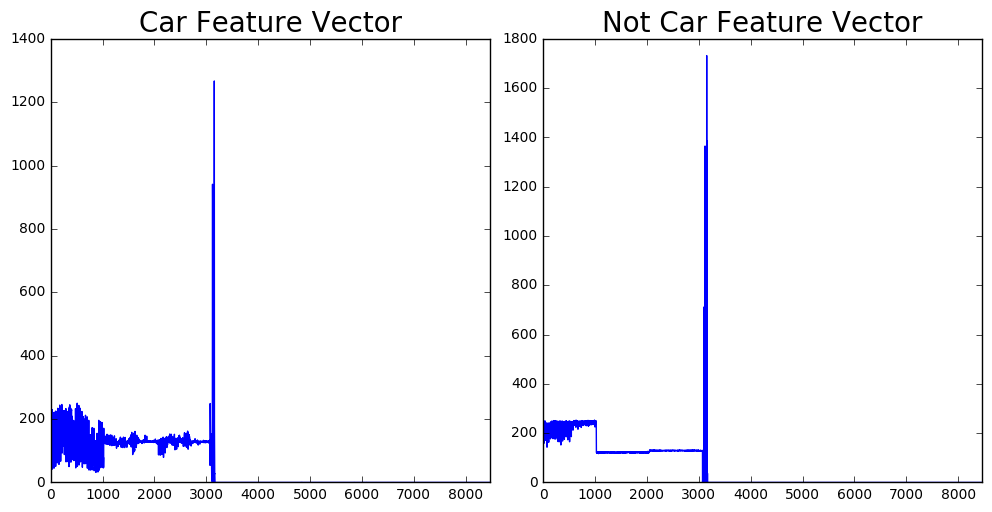

In [8]:
idx = np.random.randint(0, len(cars))
print("Feature length: ", len(car_features[idx]))
saved_unormalized = car_features[idx] # To compare between unormalized and normalized
a, fg = plt.subplots(1,2, figsize=(10, 5))
a.tight_layout()
fg[0].plot(car_features[idx])
fg[0].set_xlim([0,len(car_features[idx])])
fg[0].set_title("Car Feature Vector", fontsize=20)

fg[1].plot(not_car_features[idx])
fg[1].set_xlim([0,len(car_features[idx])])
fg[1].set_title("Not Car Feature Vector", fontsize=20)

## Normalize feature vector using StandardScaler()

In [9]:
from sklearn.model_selection import train_test_split
# Create data set
x = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print("Training feature vector's size", x.shape)
# Apply Standard Scalars to normalize vector 
X_scaler = StandardScaler().fit(x)
scaled_x = X_scaler.transform(x)

random_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=random_state)
print("Training data: Features {}, Labels {}".format(len(x_train), len(y_train)))
print("Test data: Features {}, Labels {}".format(len(x_test), len(y_test)))

Training feature vector's size (17760, 8460)
Training data: Features 14208, Labels 14208
Test data: Features 3552, Labels 3552


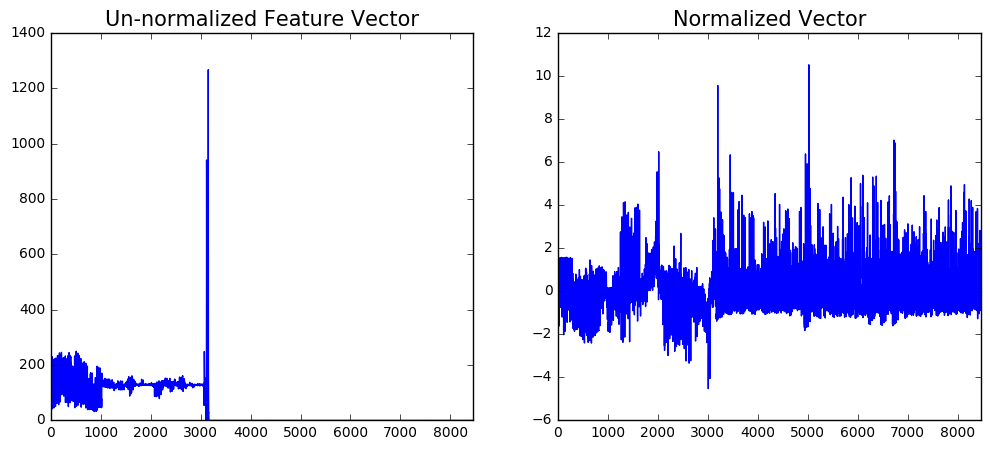

In [10]:
idx = np.random.randint(0, len(cars))
a, fg = plt.subplots(1,2, figsize=(12, 5))
fg[0].plot(saved_unormalized)
fg[0].set_xlim([0,len(x[idx])])
fg[0].set_title("Un-normalized Feature Vector", fontsize=15)
fg[1].plot(scaled_x[idx])
fg[1].set_xlim([0,len(x[idx])])
fg[1].set_title("Normalized Vector", fontsize=15)

## Build SVC Classifier and YOLO-V2 Classifier

In [11]:
# Build YOLO-V2 Classifier - I am using pre-trained model  on darkflow
yolo = YOLOV2(cfg_path="cfg/tiny-yolo-voc.cfg", weight_path="bin/tiny-yolo-voc.weights")
# yolo = YOLOV2(cfg_path="cfg/yolo-voc.cfg", weight_path="bin/yolo-voc.weights")

Parsing ./cfg/tiny-yolo-voc.cfg
Parsing cfg/tiny-yolo-voc.cfg
Loading bin/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.006954193115234375s


In [12]:
# Build SVC Classifier and train it
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

svc = Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge')),])
# Apply Standard Scalars to normalize vector
print("Start training...")
t = time.time()
svc.fit(x_train, y_train)
print("Completed Training in {:2.3f} seconds".format(time.time() - t))

# Test on testing set
score = svc.score(x_test, y_test)
print("Accuracy {:3f}%".format(score*100))


Start training...
Completed Training in 33.286 seconds
Accuracy 99.239865%


## Sliding Window and Search Window to detect cars in image for SVC

In [13]:
# Create a list of windows for SVC to select a region of image and compare with the feature vector
def slide_window(img_size, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Returns all windows to search in an image.
    No classification has been done at this stage.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_size[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] =  img_size[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, boxes, color=(0, 0, 255), thickness=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thickness)
    return draw_img

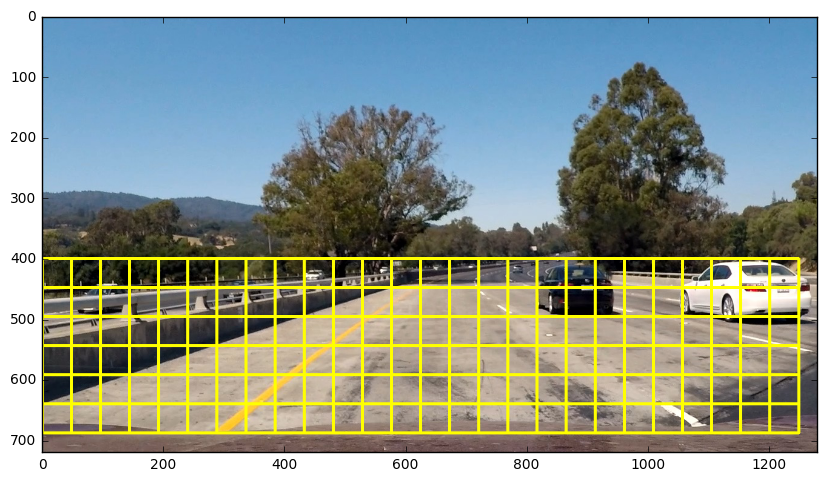

In [14]:
import itertools

test_img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
img_size = test_img.shape[:2]
windows = slide_window(img_size, x_start_stop=[None, None], y_start_stop=[400, 720],
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))


draw_img = draw_boxes(test_img, windows, color=(255, 255, 0), thickness=4)
a = plt.figure( figsize =(10, 20))
plt.imshow(draw_img)


In [15]:
def search_windows(frame, windows, clf, size=(64, 64), decision_threshold=0.3):
    on_windows = []
    for window in windows:
        # Get a region of an image
        region = cv2.resize(frame[window[0][1]:window[1][1], window[0][0]:window[1][0]], size)
        
        # Extract feature of mini image
        region_feature = np.concatenate(extract_feature(region))
        region_feature = region_feature.astype(np.float64).reshape(1,-1)
    
        # Pedict using your classifier
        dec = clf.decision_function(region_feature)
        prediction = int(dec > decision_threshold)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            #rint"Found it!"
            on_windows.append(window)
    return on_windows

def visualize(imgs):
    for img in imgs:
        a = plt.figure(figsize =(15,10))
        plt.imshow(img)

### Prediction on Test Images: SVC (regular HOG) vs YOLO v2  

Winner: **YOLO V2** ... temoprarily

In [18]:
import glob
dec_thresh = 0.75
window_size = (96, 96)
x_region = [None, None]
y_region = [400, None]
over_lap = (0.7, 0.7)
windows = slide_window(img_size, x_start_stop=x_region, y_start_stop=y_region,
                        xy_window=window_size, xy_overlap=over_lap)
print("SVC Using: {} windows at size {}, overlap {}".format(len(windows), window_size, over_lap))
svc_results = []
svc_avg_time = []
yolo_avg_time = []
yolo_results =[]
for img in glob.glob('./test_images/*.jpg')[0:4]:
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    svc_frame = frame.astype(np.float32)
    svc_img = np.copy(frame)
    yolo_img = np.copy(frame)
    # TEST SVC CLASSIFIER
    start = time.time()
    positive_windows = search_windows(svc_frame , windows, clf=svc, size=(64,64),decision_threshold=dec_thresh)
    svc_avg_time.append(time.time()-start)

    # TEST YOLOV2 CLASSIFIER
    start = time.time()
    windows = yolo.predict(frame)
    yolo_avg_time.append(time.time()-start)        
    print("SVC Found: {} results || YOLO Found: {} results".format(len(positive_windows), len(windows)))

    for p1, p2 in itertools.chain(positive_windows):
        # Draw SVC boxes
        cv2.rectangle(svc_img, p1, p2, (0,255,0), 4)  
    svc_results.append(svc_img)

    # Draw YOLO boxes
    yolo_img = draw_boxes(yolo_img, windows)
    yolo_results.append(yolo_img)
print("SVC Average processing time per img, {} seconds ".format(np.round(np.mean(svc_avg_time),4)))
print("YOLO Average processing time per img, {} seconds ".format(np.round(np.mean(yolo_avg_time),4)))

SVC Using: 440 windows at size (96, 96), overlap (0.7, 0.7)
SVC Found: 17 results || YOLO Found: 1 results
SVC Found: 0 results || YOLO Found: 0 results
SVC Found: 0 results || YOLO Found: 1 results
SVC Found: 0 results || YOLO Found: 0 results
SVC Average processing time per img, 0.4612 seconds 
YOLO Average processing time per img, 0.4407 seconds 


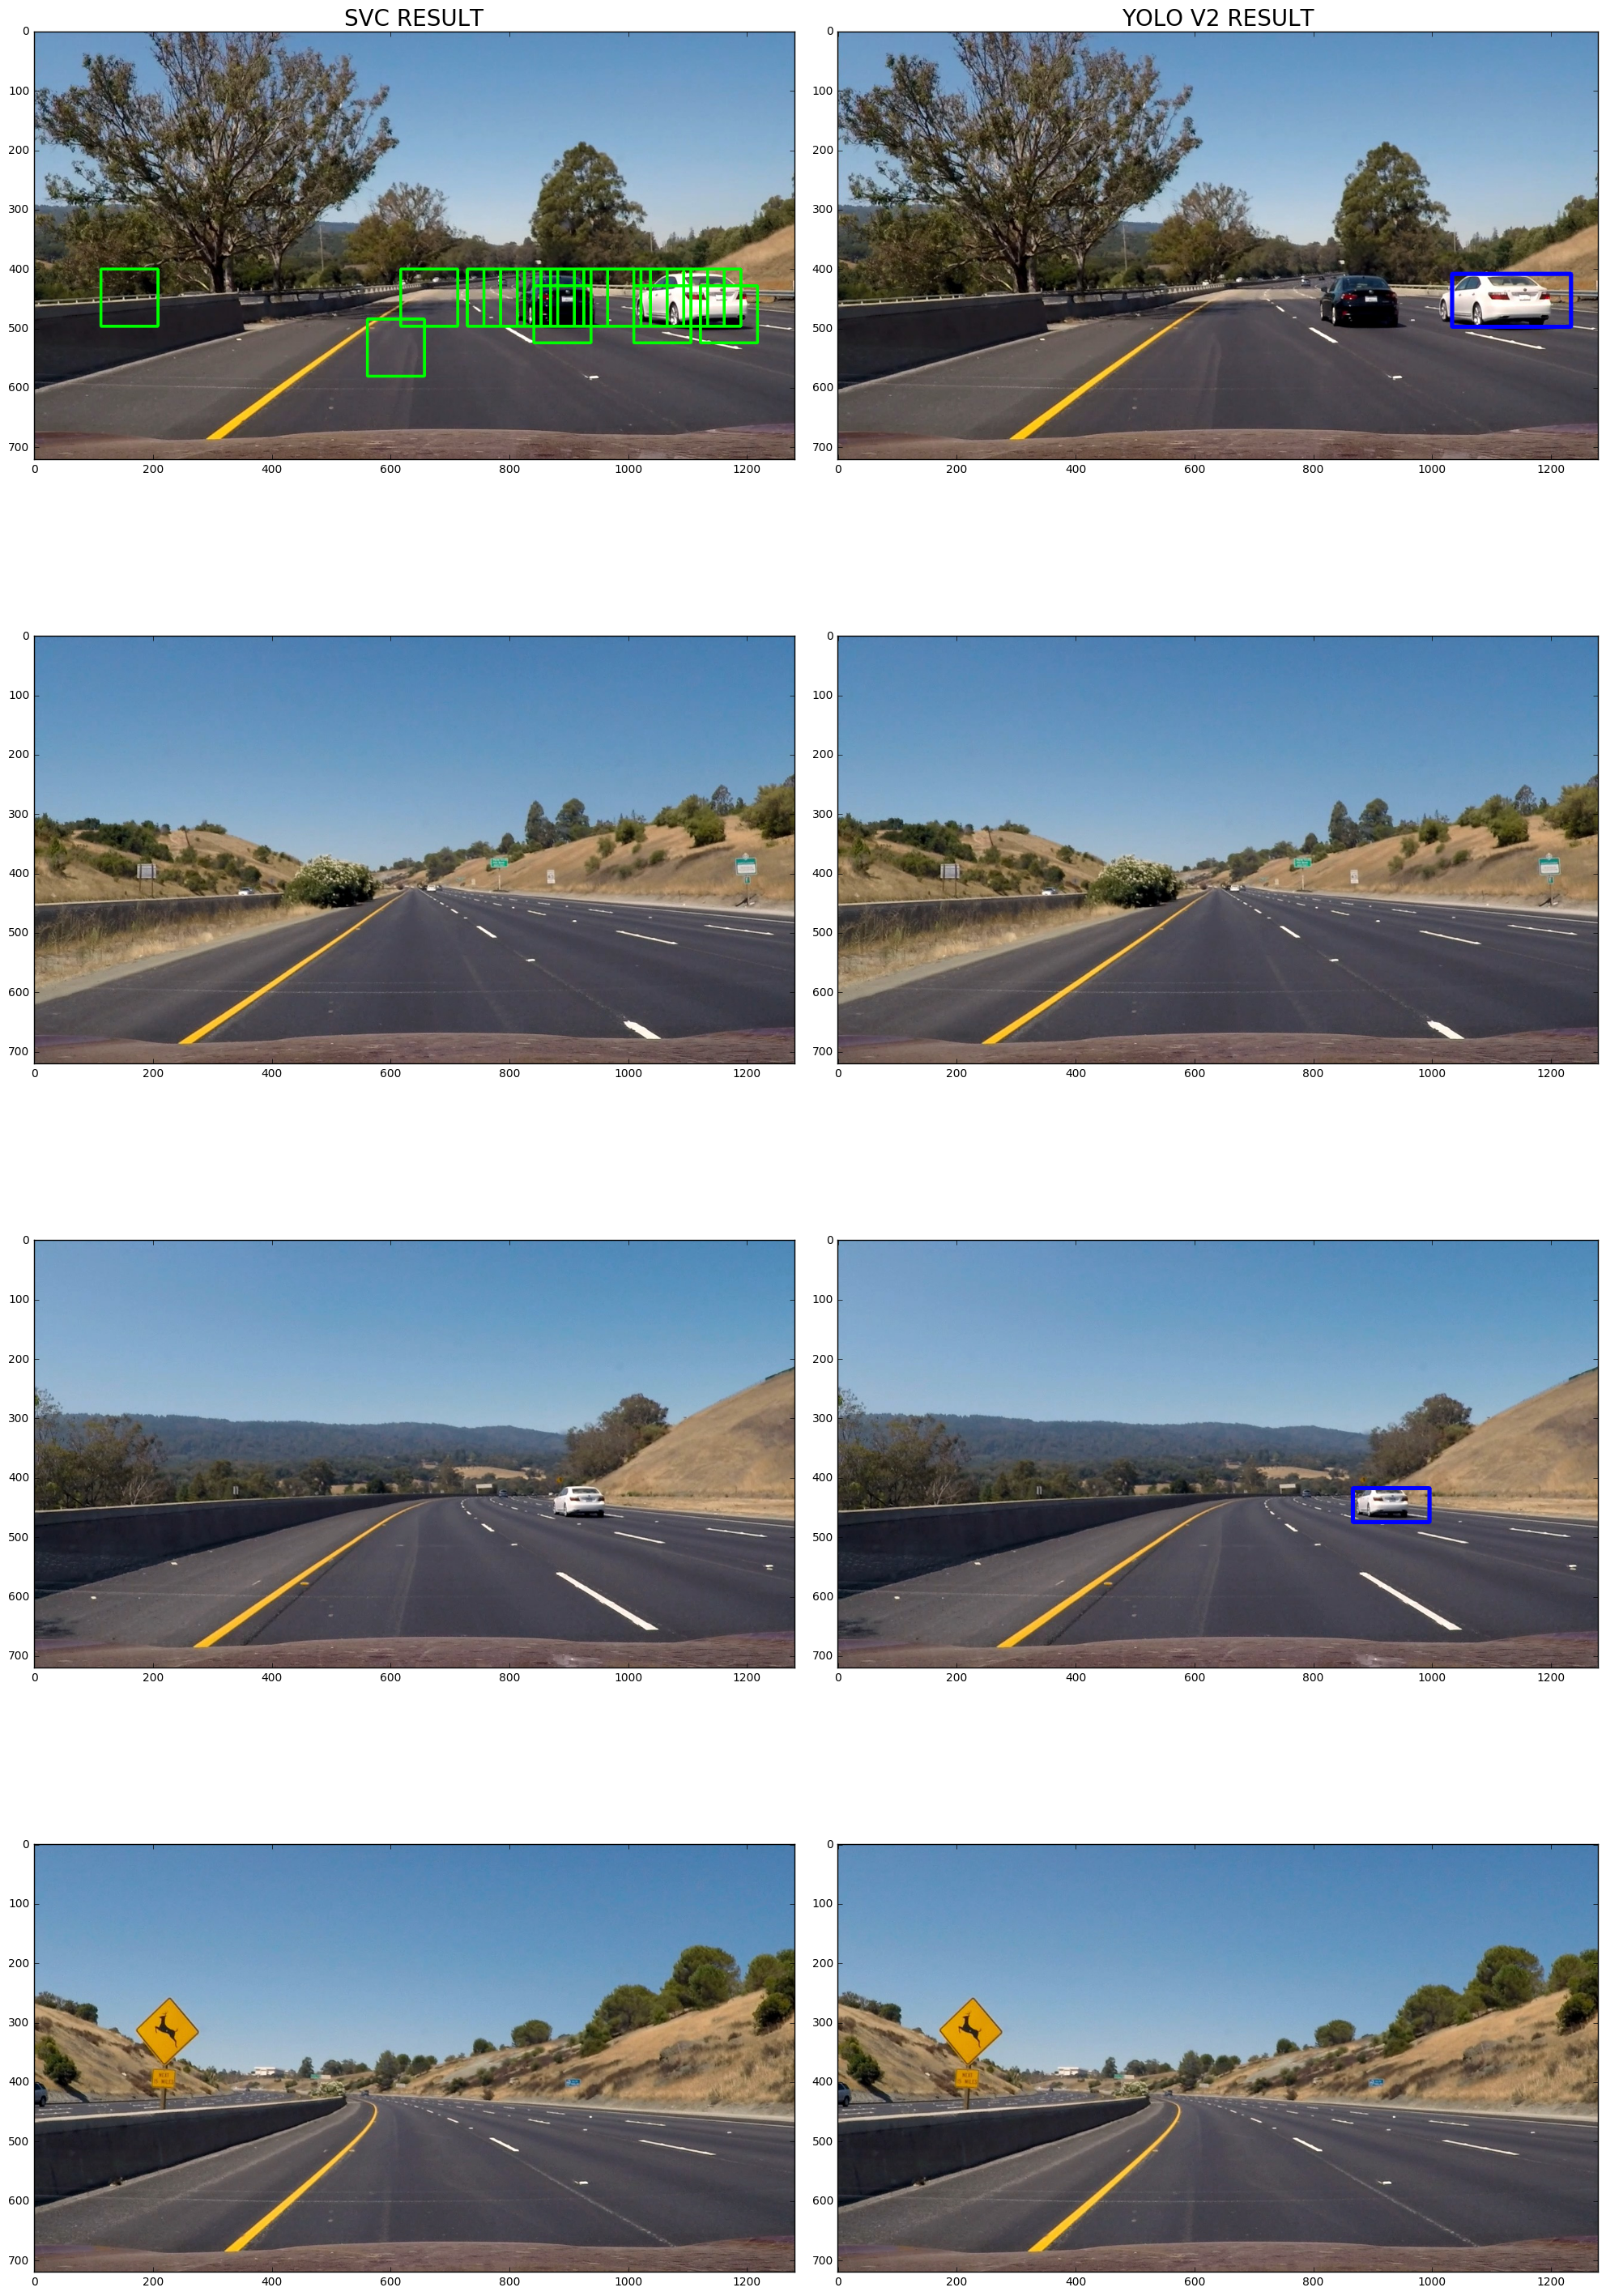

In [19]:
size = len(svc_results)
fg, a = plt.subplots(size, 2, figsize =(20,30))
fg.tight_layout()
a[0, 0].set_title("SVC RESULT", fontsize=20)
a[0, 1].set_title("YOLO V2 RESULT", fontsize=20)

for i in range(size):
    a[i, 0].imshow(svc_results[i])
    a[i, 1].imshow(yolo_results[i])

## Subsampling HOG entire image and add Heatmap

In [20]:
# Apply HOG on entire image then subsampling it
from utils import get_hog_features, bin_spatial, color_hist, convert_color
    
def find_cars(img, ystart, ystop, scale, svc, dec_thresh = 0.75, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=32, hist_bins=32):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    # Make a heat map of zero
    heatmap = np.zeros_like(img[:, : ,0])
    
    img_to_search = img[ystart:ystop, :, :]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_to_search.shape[1] // pix_per_cell) - 1
    nyblocks = (ctrans_to_search.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_to_search,ch=0, feature_vec=False)
    hog2 = get_hog_features(ctrans_to_search,ch=1, feature_vec=False)
    hog3 = get_hog_features(ctrans_to_search,ch=2, feature_vec=False)

    img_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_to_search[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            # Pedict using your classifier
            dec = svc.decision_function(test_features)
            prediction = int(dec > dec_thresh)

            # If positive (prediction == 1) then save the window
            if prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+ystart+win_draw)))
    return heatmap, img_boxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return threshold-ed map
    return heatmap

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Improved SVC vs YOLO V2

### Winner: SVC

In [42]:
dec_thresh = 0.95
ystart = 400
ystop = 656
scale = 1.3

yolo_avg_time = []
yolo_results = []
svc_results = []
svc_avg_time = []
heatmap_results = []

for img in glob.glob('./test_images/*.jpg'):
    # Open new image
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    svc_img = np.copy(frame)
    yolo_img = np.copy(frame)
    
    # SVC CLASSIFIER
    start = time.time()
    heatmap, windows = find_cars(frame, ystart, ystop, scale, svc, dec_thresh = 0.99)
    svc_avg_time.append(time.time() - start)
    
    # YOLOV2 CLASSIFIER
    start = time.time()
    yolo_windows = yolo.predict(frame)
    yolo_avg_time.append(time.time()-start)

    # Draw YOLO boxes
    yolo_img = draw_boxes(yolo_img, yolo_windows)
    
    # Process heatmap to filterout false positive
    heatmap = apply_threshold(heatmap, 2.8)
    labels = label(heatmap)
    svc_img = draw_labeled_bboxes(svc_img, labels)
    heatmap = np.clip(heatmap, 0, 255)
    print("SVC found : {} results / Max Heatmap: {} || YOLO-V2 found: {} results\n".format(len(labels), np.max(heatmap),len(yolo_windows)))
    # Update result
    yolo_results.append(yolo_img)   
    svc_results.append(svc_img)
    heatmap_results.append(heatmap)
    
print("SVC Average processing time per img, {} seconds ".format(np.round(np.mean(svc_avg_time),4)))
print("YOLO Average processing time per img, {} seconds ".format(np.round(np.mean(yolo_avg_time),4)))

SVC found : 2 results / Max Heatmap: 7.0 || YOLO-V2 found: 1 results

SVC found : 2 results / Max Heatmap: 0.0 || YOLO-V2 found: 0 results

SVC found : 2 results / Max Heatmap: 0.0 || YOLO-V2 found: 1 results

SVC found : 2 results / Max Heatmap: 3.0 || YOLO-V2 found: 0 results

SVC found : 2 results / Max Heatmap: 6.0 || YOLO-V2 found: 1 results

SVC found : 2 results / Max Heatmap: 10.0 || YOLO-V2 found: 1 results

SVC found : 2 results / Max Heatmap: 9.0 || YOLO-V2 found: 2 results

SVC found : 2 results / Max Heatmap: 10.0 || YOLO-V2 found: 1 results

SVC Average processing time per img, 0.4654 seconds 
YOLO Average processing time per img, 0.4299 seconds 


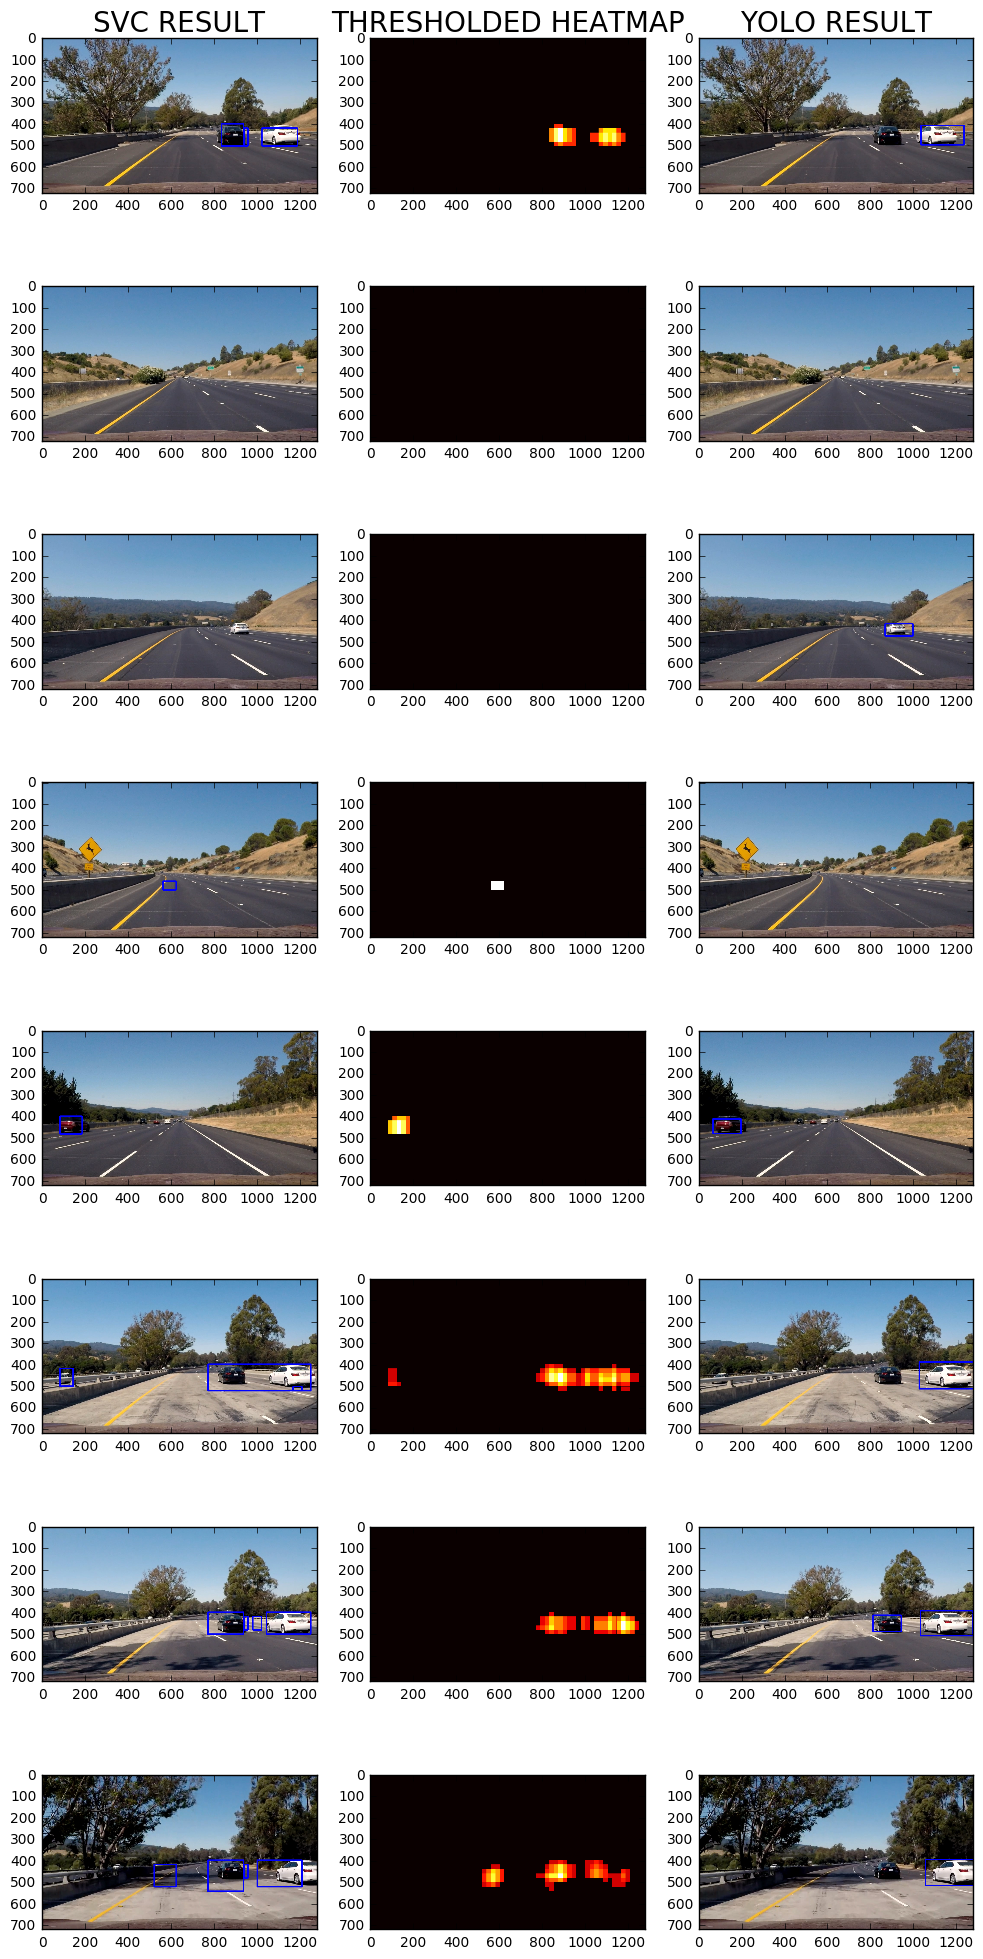

In [44]:
size = len(svc_results)
fg, a = plt.subplots(size, 3, figsize =(10,20))
fg.tight_layout()
a[0, 0].set_title("SVC RESULT", fontsize=20)
a[0, 1].set_title("THRESHOLDED HEATMAP", fontsize=20)
a[0, 2].set_title("YOLO RESULT", fontsize=20)

for i in range(size):
    a[i, 0].imshow(svc_results[i])
    a[i, 1].imshow(heatmap_results[i], cmap='hot')
    a[i, 2].imshow(yolo_results[i])

### VEHICLE TRACKER

It observes the changes of heatmap over several previous frames `looking_back_frames` to determine where to add the car bounding boxes.

In [45]:
class VehicleTracker(object):
    def __init__(self, looking_back_frames=5):
        
        # A list of bounding boxes for each vehicles
        self.tracked_vehicles = []
        #  List of previous heat_map
        self.heat_map = []
        # How far to look back
        self.smooth_factor = looking_back_frames

    def update(self, new_heat_map, threshold=10):
        
        # If we are just started to recording, keep summing
        if len(self.heat_map) < self.smooth_factor:
            if len(self.heat_map) > 2:
                # Check False Positive. 
                new_heat_map[(new_heat_map -  self.heat_map[-1]) < 0] = 0
                
            self.heat_map.append(new_heat_map)
            updated_map = np.sum(self.heat_map, axis=0)
        else:
            # Check False Positive.
            new_heat_map[(new_heat_map - self.heat_map[-1]) < 0] = 0
              
            # Add new map to current heatmap
            self.heat_map.append(new_heat_map)
            updated_map = np.sum(self.heat_map, axis=0)
            
            # Remove the earliest heat map
            earliest_map = self.heat_map.pop(0)
            updated_map -= earliest_map

        # Remove objects that are not cars - low threshold
        updated_map[updated_map <= threshold] = 0
        
        # Create an heat image
        img = 255*updated_map/np.max(updated_map)
        img = np.dstack((img, updated_map, updated_map)).astype(np.uint8)

        labels = label(updated_map)
        cars = self.draw_car_box(labels)

        # Update car bounding boxes
        cars 
        return cars, img

    def draw_car_box(self, labels):
        # Iterate through all detected cars
        car_boxes = []
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            # Determine if new box is existed in current boxes
            
            car_boxes.append(bbox)
        return car_boxes

In [48]:
# Parameter
ystart = 400
ystop = 656
scale = 1.1
# Vehicle Tracker
car_tracker = VehicleTracker(looking_back_frames=5)

def process_image(frame):
    global svc
    global car_tracker
    global ystar, ystop, scale

    svc_img = np.copy(frame)
    heatmap, windows = find_cars(frame, ystart, ystop, scale, svc, dec_thresh=0.99)
    cars, heatmap = car_tracker.update(heatmap, threshold=12.0)
    for p1, p2 in itertools.chain(cars):
        # Draw SVC boxes
        cv2.rectangle(svc_img, p1, p2, (255, 255, 0), 3)

    svc_img = cv2.addWeighted(svc_img, 0.8, heatmap, 1.0, 0.0)
    return svc_img

In [ ]:
from moviepy.editor import VideoFileClip

output = 'output.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(14, 32)
clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 13%|█▎        | 60/451 [00:43<04:51,  1.34it/s]